In [1]:
import ollama

# nomic-embed-text has a dimention of 768
ollama.embeddings(model='nomic-embed-text', prompt='hello i am a chatbot')

{'embedding': [-0.4311169981956482,
  0.8792409896850586,
  -2.717952251434326,
  -0.485435426235199,
  1.649688482284546,
  0.829401969909668,
  -0.2572478652000427,
  0.9152292013168335,
  -0.4695773422718048,
  -0.5270613431930542,
  -1.6804478168487549,
  1.4245051145553589,
  -0.4633418321609497,
  0.6075001358985901,
  -0.5844593048095703,
  -0.715745210647583,
  0.06860683113336563,
  -1.0251216888427734,
  -0.7618282437324524,
  0.6004981398582458,
  -1.061554193496704,
  -0.7616162896156311,
  0.13012820482254028,
  0.18311342597007751,
  2.492640733718872,
  1.1053268909454346,
  -0.36508435010910034,
  1.5583984851837158,
  -0.42066946625709534,
  -0.33325502276420593,
  0.4229772090911865,
  -0.2979460656642914,
  -0.8663895130157471,
  0.9719053506851196,
  -0.6995201110839844,
  -1.2726752758026123,
  0.4871468245983124,
  -0.9972885251045227,
  0.5745632648468018,
  1.7754155397415161,
  0.5182722806930542,
  0.9312703609466553,
  -0.26175203919410706,
  -0.4710964560508

In [31]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings_3d(words, embedding_model='nomic-embed-text'):
    # Dictionary to store embeddings
    vector_store = {}
    
    # Generate embeddings using ollama
    for word in words:
        embedding = ollama.embeddings(model=embedding_model, prompt=word)
        vector_store[word] = embedding['embedding']  # Assuming the embedding is stored under 'embedding' key
    
    # Convert embeddings to a numpy array for PCA
    embeddings = np.array([vector_store[word] for word in words])
    
    # Apply PCA to reduce to 3 dimensions
    pca = PCA(n_components=3)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Plot the 3D graph
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each word in the 3D space
    for i, word in enumerate(words):
        ax.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], label=word)
        ax.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], word)
    
    # Set labels for the axes
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    
    # Show the plot
    plt.show()

In [32]:
words = ['Cease', 'terminate', 'desist', 'Begin', 'Originate', 
         'Abundant', 'Plentiful', 'Scarce', 'Limited', 'Ample', 'Bountiful', 'Rare']

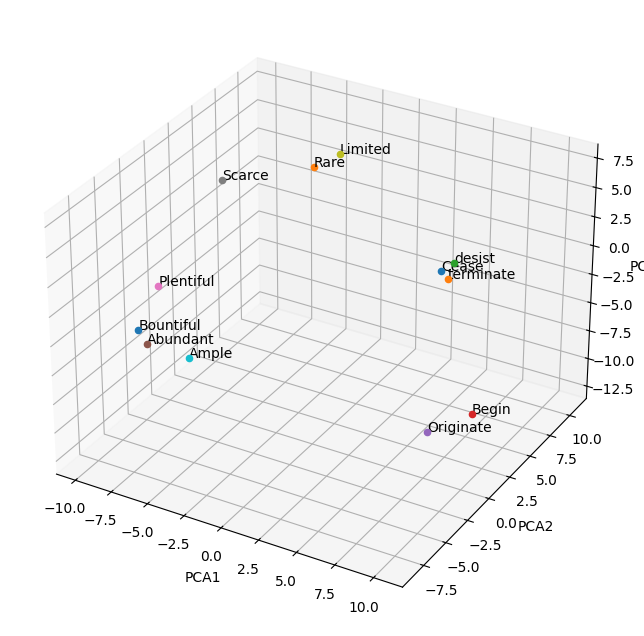

In [33]:
plot_embeddings_3d(words)

In [16]:
import weaviate
import weaviate.classes.config as wc
import weaviate.classes as wvc

client = weaviate.connect_to_local()

if not client.collections.exists(name = 'dev_day_demo'):
    client.collections.create(name = 'dev_day_demo')

collection = client.collections.get('dev_day_demo')

In [17]:
weaviate_docs = []

for index, word in enumerate(words):
    weaviate_doc = wvc.data.DataObject(
        properties={
            'message': word,
        },
        vector=list(ollama.embeddings(model='nomic-embed-text', prompt=word)['embedding'])
    )
    weaviate_docs.append(weaviate_doc)
      

In [18]:
collection.data.insert_many(weaviate_docs)

BatchObjectReturn(_all_responses=[UUID('0f852a69-9084-439f-9958-579a52f5e60e'), UUID('16089000-79a8-42d0-a6c8-d01ab59a5c79'), UUID('81d07afc-bd86-44a3-aeb8-4edd609dd328'), UUID('dd3f1344-49c6-4251-b034-5af00b19a899'), UUID('e97bc71f-d99e-4b87-8f2a-bc4d09a88c7d'), UUID('e840ca16-2c19-4e33-b194-3816b6f931a8'), UUID('5447e6dc-3b60-4178-a964-94e9bad3783c'), UUID('09a170ad-acd2-4300-85cb-8a9e10bfaf7c'), UUID('381c488d-faaf-458d-8e12-07be6a414ab4'), UUID('9429dfa9-2ae0-4094-929e-27c07a2f1990'), UUID('528ce8a4-8d03-42d6-994c-4e5e92bc372b'), UUID('1ea16a2f-af87-4ddc-8680-de2b29cf05a6')], elapsed_seconds=0.029312849044799805, errors={}, uuids={0: UUID('0f852a69-9084-439f-9958-579a52f5e60e'), 1: UUID('16089000-79a8-42d0-a6c8-d01ab59a5c79'), 2: UUID('81d07afc-bd86-44a3-aeb8-4edd609dd328'), 3: UUID('dd3f1344-49c6-4251-b034-5af00b19a899'), 4: UUID('e97bc71f-d99e-4b87-8f2a-bc4d09a88c7d'), 5: UUID('e840ca16-2c19-4e33-b194-3816b6f931a8'), 6: UUID('5447e6dc-3b60-4178-a964-94e9bad3783c'), 7: UUID('09a17

In [19]:
retrieved_docs = collection.query.near_vector(
    near_vector=list(ollama.embeddings(model='nomic-embed-text', prompt='more than enough')['embedding']),
    limit=2,
    return_metadata=wvc.query.MetadataQuery(certainty=True)
)

[(o.properties['message'], o.metadata.certainty) for o in retrieved_docs.objects]


[('Abundant', 0.7813969850540161), ('Plentiful', 0.775922954082489)]

In [20]:
retrieved_docs = collection.query.near_vector(
    near_vector=list(ollama.embeddings(model='nomic-embed-text', prompt='in short supply')['embedding']),
    limit=2,
    return_metadata=wvc.query.MetadataQuery(certainty=True)
)

[(o.properties['message'], o.metadata.certainty) for o in retrieved_docs.objects]

[('Limited', 0.8176659345626831), ('Scarce', 0.7924264669418335)]